library import

In [1]:
%matplotlib inline
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import fetch_kddcup99, fetch_covtype, fetch_mldata
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle as sh
from sklearn.model_selection import train_test_split

外れ値検知:Isolation Forest

In [2]:
def print_outlier_ratio(y):
    uniq, cnt = np.unique(y, return_counts=True)
    print("----- Target count values: ")
    for u, c in zip(uniq, cnt):
        print("------ %s -> %d occurrences" % (str(u), c))
    print("----- Outlier ratio: %.5f" % (np.min(cnt) / len(y)))

In [3]:
np.random.seed(1)
with_decision_function_histograms = False
datasets = 'SA'

In [4]:
# Loading and vectorizing the data:
print('====== %s ======' % datasets)
print('--- Fetching data...')
dataset = fetch_kddcup99(subset=datasets, shuffle=True, percent10=True)
X = dataset.data
y = dataset.target

====== SA ======
--- Fetching data...


In [10]:
print('--- Vectorizing data...')

if datasets == 'SA':
    lb = MultiLabelBinarizer()
    x1 = lb.fit_transform(X[:, 1])
    x2 = lb.fit_transform(X[:, 2])
    x3 = lb.fit_transform(X[:, 3])
    X = np.c_[X[:, :1], x1, x2, x3, X[:, 4:]]
    y = (y != b'normal.').astype(int)
    print_outlier_ratio(y)

n_samples, n_features = X.shape
n_samples_train = n_samples // 2

X = X.astype(float)
X_train = X[:n_samples_train, :]
X_test = X[n_samples_train:, :]
y_train = y[:n_samples_train]
y_test = y[n_samples_train:]

--- Vectorizing data...
----- Target count values: 
------ 0 -> 97278 occurrences
------ 1 -> 3377 occurrences
----- Outlier ratio: 0.00000


--- Fitting the IsolationForest estimator...
--- Preparing the plot elements...
SA (AUC: 0.998, train_time= 8.63s, test_time= 3.73s)


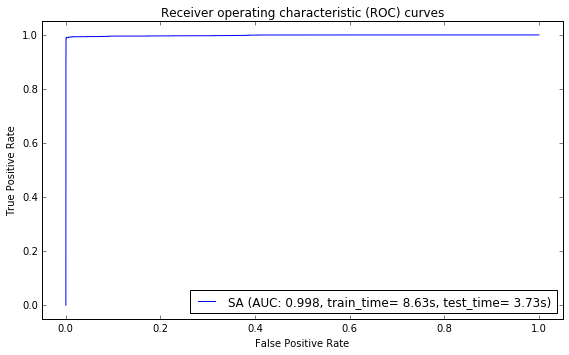

In [11]:
print('--- Fitting the IsolationForest estimator...')
model = IsolationForest(n_jobs=-1)
tstart = time()
model.fit(X_train)
fit_time = time() - tstart
tstart = time()

scoring = - model.decision_function(X_test)  # the lower, the more abnormal

print("--- Preparing the plot elements...")
if with_decision_function_histograms:
    fig, ax = plt.subplots(3, sharex=True, sharey=True)
    bins = np.linspace(-0.5, 0.5, 200)
    ax[0].hist(scoring, bins, color='black')
    ax[0].set_title('Decision function for %s dataset' % dat)
    ax[1].hist(scoring[y_test == 0], bins, color='b', label='normal data')
    ax[1].legend(loc="lower right")
    ax[2].hist(scoring[y_test == 1], bins, color='r', label='outliers')
    ax[2].legend(loc="lower right")

# Show ROC Curves
predict_time = time() - tstart
fpr, tpr, thresholds = roc_curve(y_test, scoring)
auc_score = auc(fpr, tpr)
label = ('%s (AUC: %0.3f, train_time= %0.2fs, '
            'test_time= %0.2fs)' % (datasets, auc_score, fit_time, predict_time))
# Print AUC score and train/test time:
print(label)

fig_roc, ax_roc = plt.subplots(1, 1, figsize=(8, 5))
ax_roc.plot(fpr, tpr, lw=1, label=label)

ax_roc.set_xlim([-0.05, 1.05])
ax_roc.set_ylim([-0.05, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('Receiver operating characteristic (ROC) curves')
ax_roc.legend(loc="lower right")
fig_roc.tight_layout()
plt.show()

In [12]:
if_test = model.predict(X_test)

In [13]:
if_result = 0
yif_test = []
for i in range(0,len(y_test)):
    if y_test[i] == 0:
        yif_test.append(1)
    else:
        yif_test.append(-1)
    
    if if_test[i] == yif_test[i]:
        if_result = if_result + 1

print if_result*100.0/len(y_test)

90.5976792243


識別タスク：Random Forest

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50)
clf = RandomForestClassifier(max_depth=8, random_state=0)

In [19]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [20]:
rf_test = clf.predict(X_test)

In [21]:
l = 0
for i in range (0,len(rf_test)):
    if y_test[i] == rf_test[i]:
        l = l + 1
print l*100.0/len(rf_test)

99.9701955174
